In [1]:
#Useful things
import networkx as nx
import numpy as np
import pandas as pd

import sklearn as sk
import sklearn.model_selection
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering

import scipy as sp
import matplotlib.pyplot as plt
import random

#Persistent Homology
import gudhi as gd


In [2]:
#Takes a graph, plots the persistency diagram then adds edges and plots it again
class graphMorpher():
    
    def __init__(self,nodes,graph):
        self.n = nodes
        self.g_0 = graph.copy() #Pre-morphing
        self.g_1 = graph.copy() #Post-morphing
        
    #Code for adding edges randomly
    def randomEdgeAdder(self,percent_Edges,target = None):
        nodes = list(range(0,self.n))

        if target == None:
            target = nodes.pop(random.randrange(len(nodes)))
        else:
            target = nodes.pop(target)

        nodes = set(nodes)

        nodes.difference_update(set(self.g_0.neighbors(target)))

        nodes = list(nodes)

        new_Edges = np.int(percent_Edges*self.n)

        for i in range(new_Edges):
            
            if len(nodes) == 0:
                break
            
            self.g_1.add_edge(target,nodes.pop(random.randrange(len(nodes))))
        
    #Draws the graph
    def drawGraph(self,graph,pos):
        nx.draw(graph,pos)

    #Produces persistency diagram using the distance matrix
    def persistDiagram(self, graph, max_dim=2, plot_diag = True, return_codes = True):
        self.distMapMaker(graph)
        
        rips = gd.RipsComplex(self.distMap)
        simplex = rips.create_simplex_tree(max_dimension=2)
        barcodes = simplex.persistence()
        
        if plot_diag == True:
            gd.plot_persistence_diagram(barcodes,legend=True)
            
        if return_codes == True:
            return barcodes
    
    #Generates the distance matrix based on the shortest path between nodes
    def distMapMaker(self,graph):
        self.distMap = np.zeros((self.n,self.n))
        
        for i in range(self.n):
            for j in range(i,self.n):

                if i == j: #Diagonals are always distance 0 from themselves (If N is 0, 0 * inf returns NaN)
                        self.distMap[i][j] = 0.0
                else:
                    if nx.has_path(graph,i,j) == False:
                        self.distMap[i][j] = 2 * len(graph)
                    else:
                        self.distMap[i][j] = len(nx.shortest_path(graph,i,j))-1 #subtract 1 as given as list of nodes in shortest path, number of edges is this number minus 1

                if self.distMap[i][j] == np.inf: #Fix nodes that will never be activated (when P is zero or they aren't connected)
                    self.distMap[i][j] = 2*len(g)

                self.distMap[j][i] = self.distMap[i][j]

                
    #Formats the barcodes in a way that's bottleneck distance ocmpatible
    def barcodeFormatter(self,barcode,dimension):
        list = []

        array = np.array(barcode)
        array = array[array[:,0] == dimension]
        array = array[:,1]

        for i in array:
            list.append([i[0],i[1]])

        return list
    
    #Calculate the bottlneeck distance between two persistence diagrams for type-0 and tpye-1 features
    def compareGraphs(self, percent_Edges, target = None, 
                      return_codes = False, draw_diags=True, print_distances=True, return_bottlenecks=False):
        
        barcodes_1 = self.persistDiagram(self.g_0,plot_diag=draw_diags,return_codes=True)
        
        self.randomEdgeAdder(percent_Edges,target = target)
    
        barcodes_2 = self.persistDiagram(self.g_1,plot_diag=draw_diags,return_codes=True)
        
        if return_codes == True:
            return barcodes_1, barcodes_2
        
        barcodes_1_1 = self.barcodeFormatter(barcodes_1,1)
        barcodes_2_1 = self.barcodeFormatter(barcodes_2,1)
        barcodes_1_0 = self.barcodeFormatter(barcodes_1,0)
        barcodes_2_0 = self.barcodeFormatter(barcodes_2,0)
        
        dim_1_bottleneck = gd.bottleneck_distance(barcodes_1_1,barcodes_2_1,e=0)
        dim_0_bottleneck = gd.bottleneck_distance(barcodes_1_0,barcodes_2_0,e=0)
        
        if print_distances == True:
            print('Dimension 0 bottleneck distance is ',dim_0_bottleneck)
            print('Dimension 1 bottleneck distance is ',dim_1_bottleneck)
        
        if return_bottlenecks == True:
            return dim_0_bottleneck, dim_1_bottleneck
    
    #Generate the bottleneck distances between the persistence diagrams calculated on the graph with edges generated over a range of P values
    def bottleneckArray(self,P_values,target = None):
        bottleneck_array = np.zeros((len(P_values),2))
        
        for i in range(len(P_values)):
            self.g_1 = self.g_0.copy() #Need to reset the graph after each iteration
            bottleneck_array[i][0], bottleneck_array[i][1] = self.compareGraphs(percent_Edges = P_values[i], target = target,
                                                                                draw_diags=False, print_distances = False, 
                                                                                       return_bottlenecks=True)
            
        return bottleneck_array

In [3]:
#Makes Noisy Rings
class noisyRingMaker():
    
    def __init__(self,nodes,geo_edges,non_geo_edges):
        self.n = nodes
        self.g = nx.random_geometric_graph(self.n,0)
        self.geo_edges = geo_edges
        self.non_geo_edges = non_geo_edges
        self.edge_total = geo_edges + non_geo_edges
        self.pos = nx.circular_layout(self.g)
        self.distMat_exists = False
        
    #Make distance matrix for 2d Norm
    def twoD_distMat(self):
        self.distMat = np.zeros((self.n,self.n))

        for i in range(self.n):
            for j in range(i,self.n):
                self.distMat[i][j] = np.linalg.norm(self.pos[i]-self.pos[j])
                self.distMat[j][i] = self.distMat[i][j]
                
        self.distMat_exists = True
                
    #Adds edges between closest nodes
    def geometricEdgeAdder(self):
        nodes = []

        for i in range(self.distMat.shape[0]):
            nodes.append(np.argsort(self.distMat[i])[:self.geo_edges+1]) #Counts itself as one of its closest nodes so the +1 just compensates for that

        for n in self.g.nodes():
            for i in nodes[n]:
                if n != i: #Avoid self edges
                    self.g.add_edge(n,i)
                    
    #Version to run after geometric edges already added
    def nonGeometricEdgeAdder(self,debugging = True):
        degrees = np.array(self.g.degree)
        error = False
            
        for n in list(self.g.nodes()):
            
            if self.g.degree(n) == self.edge_total: #If the node already has enough connections
                continue #Move on to next node

            #Make a list of nodes that can be connected
            possible_nodes = list(self.g.nodes())
            max_degrees = list(degrees[degrees[:,1]==self.edge_total][:,0]) #Return a list of nodes with maximum degree
            exclude = list(self.g.neighbors(n)) + [n] + max_degrees
            exclude = list(dict.fromkeys(exclude)) #Remove duplicates
            
            for i in exclude: #Remove nodes that aren't eligible
                possible_nodes.remove(i)
                    
            if not possible_nodes: #If there's no possible connections (Shouldn't happen for sufficiently small geo k and enough n)
                if debugging == True:
                    print('No available nodes for node',n)
                error = True
                break

            for i in range(self.edge_total-self.g.degree(n)): #While the number of edges of that node is below the required total

                if len(possible_nodes) < self.edge_total-self.g.degree(n):
                    if debugging == True:
                        print('Not enough viable nodes for node',n)
                    error = True
                    break

                second_node = possible_nodes.pop(np.random.randint(len(possible_nodes))) #Pop out a random viable node (Popping means it won't be picked again when adding more edges)

                self.g.add_edge(n,second_node)
                
            if error == True:
                break
                
            degrees = np.array(self.g.degree)

            
    #Check the degree of each node is the same
    def checkDegrees(self):
        degrees = list(np.array(self.g.degree)[:,1])

        return all(elem == self.edge_total for elem in degrees)
     
    #Construct the ring        
    def makeNoisyRing(self,draw_Graph = True,debugging = False):
        if debugging == True:
            count = 1
        
        if (self.n % 2 == 1) or (self.geo_edges % 2 == 1):
            print('Please choose an even number of nodes and geometric edges')
            
        else:
            if debugging == True:
                print('Attempt #',count)
            self.twoD_distMat() #Only need to create a distance matrix once for the geometric edge adding
            self.geometricEdgeAdder()
            self.nonGeometricEdgeAdder(debugging)

            while (self.checkDegrees() == False): #If it doesn't meet the criteria, remove all edges and start over
                if debugging == True:
                    count += 1
                    print('Attempt #',count)
                self.g = nx.create_empty_copy(self.g)
                self.geometricEdgeAdder()
                self.nonGeometricEdgeAdder(debugging)

            if draw_Graph == True:
                nx.draw(self.g,self.pos)
                      
            return self.g
        

In [4]:
n = 200 #number of nodes

P_values = np.linspace(0,1,11) #P values from 0 to 1, incrementing in 0.1

# Ring

Attempt # 1


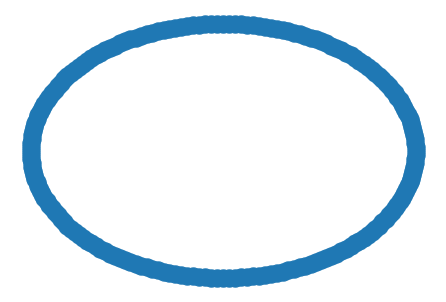

In [5]:
g_1 = noisyRingMaker(n,2,0) #Initialise the node locations
pos_1 = g_1.pos #Embed it in 2D space
g_1 = g_1.makeNoisyRing(debugging=True) #Make the graph itself with connections

Dimension 0 bottleneck distance is  7.0710678118654755
Dimension 1 bottleneck distance is  345.3746726929674


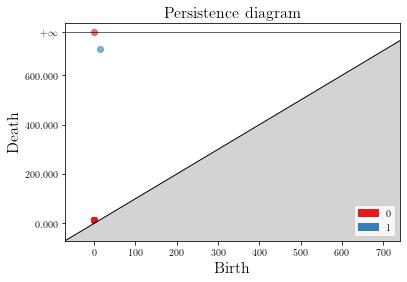

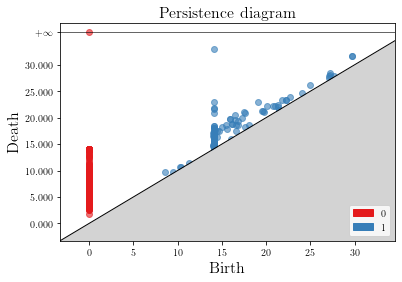

In [6]:
test_1 = graphMorpher(n,g_1) #Class used in obtaining results

test_1.compareGraphs(0.2) #Make a hub node with 20% of nodes connected, and compare before and after persistence diagrams

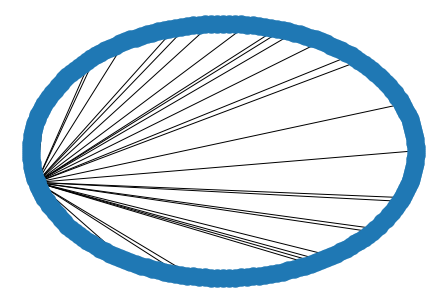

In [7]:
nx.draw(test_1.g_1,pos_1) #Plot the graph after a hub node is created

# Geometric Graph

In [8]:
g_2 = nx.random_geometric_graph(n,0.125,seed=2)
pos_2=nx.fruchterman_reingold_layout(g_2)

Dimension 0 bottleneck distance is  4.744231461913964
Dimension 1 bottleneck distance is  11.211437486916747


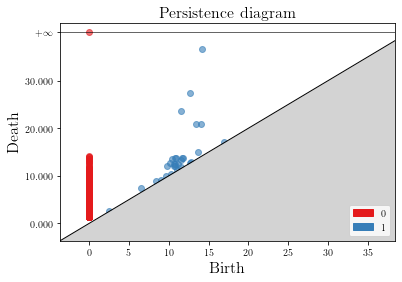

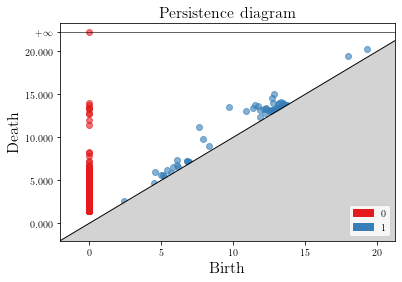

In [9]:
test_2 = graphMorpher(n,g_2)

test_2.compareGraphs(0.2)

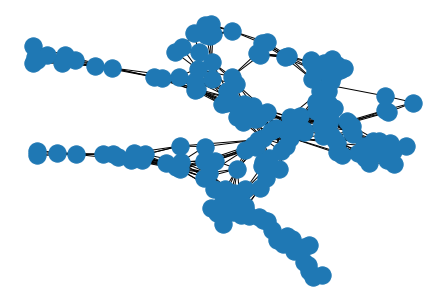

In [10]:
nx.draw(test_2.g_0,pos_2)

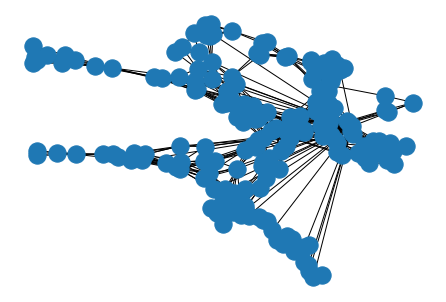

In [11]:
nx.draw(test_2.g_1,pos_2)

# Erdos-Renyi Graph

In [12]:
g_3 = nx.fast_gnp_random_graph(n,0.125,seed=0)
pos_3=nx.fruchterman_reingold_layout(g_3)

Dimension 0 bottleneck distance is  0.18678447144218868
Dimension 1 bottleneck distance is  0.1846849648621518


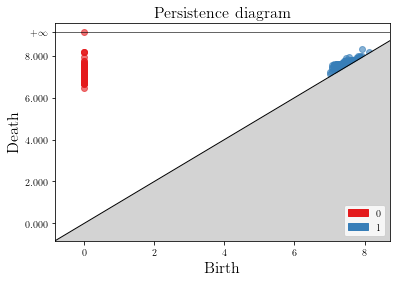

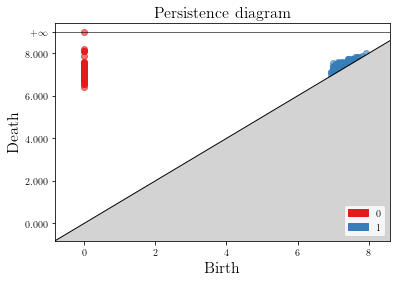

In [13]:
test_3 = graphMorpher(n,g_3)

test_3.compareGraphs(0.2,target=0)

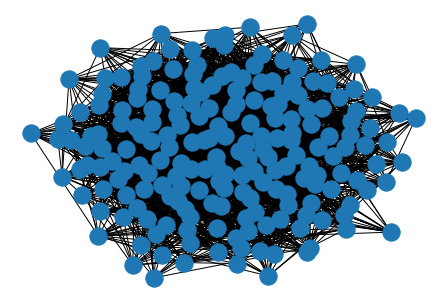

In [14]:
nx.draw(test_3.g_0,pos_3)

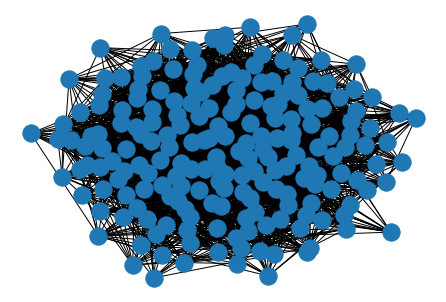

In [15]:
nx.draw(test_3.g_1,pos_3)

# Scale-Free Network

In [16]:
g_4 = nx.scale_free_graph(n)
g_4 = g_4.to_undirected()
pos_4=nx.fruchterman_reingold_layout(g_4)

Dimension 0 bottleneck distance is  1.3627881034778841
Dimension 1 bottleneck distance is  0.8504219470119541


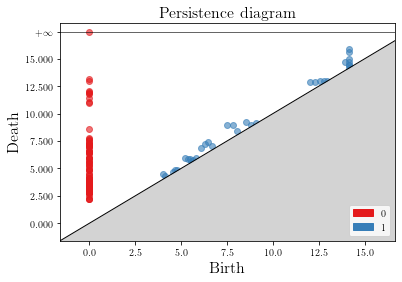

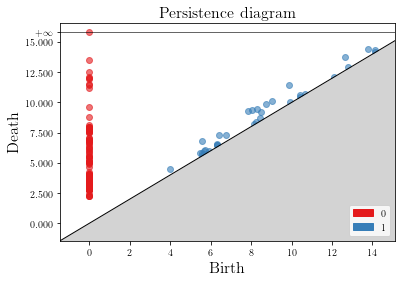

In [17]:
test_4 = graphMorpher(n,g_4)

test_4.compareGraphs(0.2,target=0)

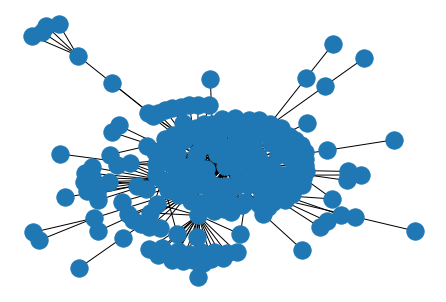

In [18]:
nx.draw(test_4.g_0,pos_4)

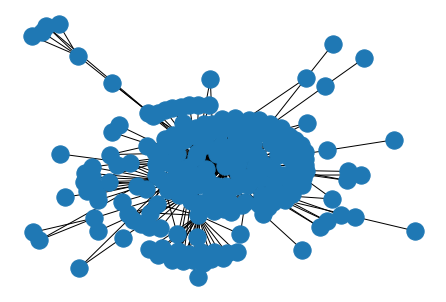

In [19]:
nx.draw(test_4.g_1,pos_4)

# Bottleneck Arrays

In [20]:
#Generate the range of bottleneck values for the noisy ring, averaging the results over n_run trials
test_1 = graphMorpher(n,g_1)
test_1_bottleneck_array = test_1.bottleneckArray(P_values)
n_runs = 10

for i in range(n_runs-1):
    test_1_bottleneck_array += test_1.bottleneckArray(P_values)

test_1_bottleneck_array = test_1_bottleneck_array / n_runs

In [21]:
test_1_bottleneck_array

array([[  0.        ,   0.        ],
       [  7.07106781, 345.37467269],
       [  7.07106781, 345.37467269],
       [  7.07106781, 345.37467269],
       [  7.07106781, 345.37467269],
       [  7.07106781, 345.37467269],
       [  7.07106781, 345.37467269],
       [  7.07106781, 345.37467269],
       [  7.07106781, 345.37467269],
       [  7.07106781, 345.37467269],
       [  7.07106781, 345.37467269]])

In [22]:
#Generate the range of bottleneck values for the random geometric graph, averaging the results over n_run trials
test_2 = graphMorpher(n,g_2)
test_2_bottleneck_array = test_2.bottleneckArray(P_values)

for i in range(n_runs-1):
    test_2_bottleneck_array += test_2.bottleneckArray(P_values)

test_2_bottleneck_array = test_2_bottleneck_array / n_runs

In [23]:
test_2_bottleneck_array

array([[ 0.        ,  0.        ],
       [ 3.31082249, 11.21143749],
       [ 3.97821523, 11.21143749],
       [ 5.34421589, 11.21143749],
       [ 5.63471383, 11.21143749],
       [ 6.09167212, 11.21143749],
       [ 6.01586106, 11.21143749],
       [ 5.75829492, 11.21143749],
       [ 5.63471383, 11.21143749],
       [ 5.89491306, 11.21143749],
       [ 7.01783442, 11.21143749]])

In [24]:
#Generate the range of bottleneck values for the Erdos-Renyi graph, averaging the results over n_run trials
test_3 = graphMorpher(n,g_3)
test_3_bottleneck_array = test_3.bottleneckArray(P_values)

for i in range(n_runs-1):
    test_3_bottleneck_array += test_3.bottleneckArray(P_values)

test_3_bottleneck_array = test_3_bottleneck_array / n_runs

In [25]:
test_3_bottleneck_array

array([[0.        , 0.        ],
       [0.07581106, 0.12700426],
       [0.35865097, 0.21541321],
       [1.14202628, 0.21541321],
       [1.45829799, 0.21890912],
       [1.81464723, 0.25681464],
       [2.81464723, 0.26554964],
       [3.64680679, 0.24037035],
       [4.42416744, 0.28608617],
       [4.50322477, 0.28608617],
       [4.6208957 , 0.28608617]])

In [26]:
#Generate the range of bottleneck values for the scale free network, averaging the results over n_run trials
test_4 = graphMorpher(n,g_4)
test_4_bottleneck_array = test_4.bottleneckArray(P_values)

for i in range(n_runs-1):
    test_4_bottleneck_array += test_4.bottleneckArray(P_values)

test_4_bottleneck_array = test_4_bottleneck_array / n_runs

In [27]:
test_4_bottleneck_array

array([[0.        , 0.        ],
       [2.50135727, 1.12758323],
       [1.25909144, 0.83033116],
       [2.7852691 , 1.15319342],
       [2.55732872, 0.8318051 ],
       [3.54361487, 0.85042195],
       [2.95445115, 0.77646034],
       [2.58785088, 0.75517011],
       [4.57872357, 0.85042195],
       [4.70945315, 0.85042195],
       [6.        , 0.85042195]])

Text(0, 0.5, 'Bottleneck Distance')

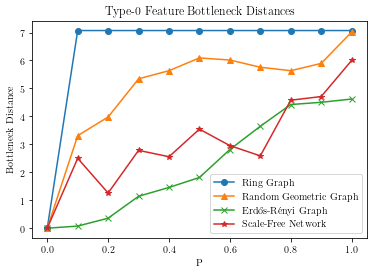

In [28]:
#Plot type-0 average bottleneck distances
plt.plot(P_values,test_1_bottleneck_array[:,0],marker='o')
plt.plot(P_values,test_2_bottleneck_array[:,0],marker='^')
plt.plot(P_values,test_3_bottleneck_array[:,0],marker='x')
plt.plot(P_values,test_4_bottleneck_array[:,0],marker='*')
plt.legend(labels=('Ring Graph','Random Geometric Graph','Erdős-Rényi Graph','Scale-Free Network'))
plt.title('Type-0 Feature Bottleneck Distances')
plt.xlabel('P')
plt.ylabel('Bottleneck Distance')

Text(0, 0.5, 'Bottleneck Distance')

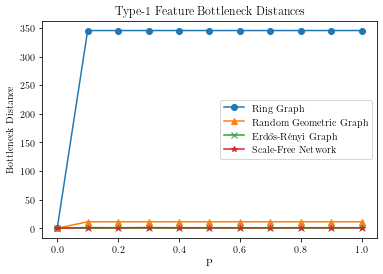

In [30]:
#Plot type-1 average bottleneck distances
plt.plot(P_values,test_1_bottleneck_array[:,1],marker='o')
plt.plot(P_values,test_2_bottleneck_array[:,1],marker='^')
plt.plot(P_values,test_3_bottleneck_array[:,1],marker='x')
plt.plot(P_values,test_4_bottleneck_array[:,1],marker='*')
plt.legend(labels=('Ring Graph','Random Geometric Graph','Erdős-Rényi Graph','Scale-Free Network'))
plt.title('Type-1 Feature Bottleneck Distances')
plt.xlabel('P')
plt.ylabel('Bottleneck Distance')

# Machine Learning Classification

In [31]:
#Format the barcodes into a usable state
def barcodeGenerator(model,P):
    barcodes_1, barcodes_2 = model.compareGraphs(P,return_codes = True,draw_diags = False, print_distances = False)
    
    barcodes_1_1 = model.barcodeFormatter(barcodes_1,1)
    barcodes_1_0 = model.barcodeFormatter(barcodes_1,0)

    barcodes_2_1 = model.barcodeFormatter(barcodes_2,1)
    barcodes_2_0 = model.barcodeFormatter(barcodes_2,0)
    
    return barcodes_1_1, barcodes_1_0, barcodes_2_1, barcodes_2_0

In [32]:
n_samples = 100 #How many graphs to generate
n_barcodes = 10 #How many barcodes to take from each

In [33]:
#Array of barcode results, with room for start and end time, and an indicator of what state it's in
barcode_array = np.zeros((n_samples*2,n_barcodes*4 + 1))

#Generate am Erdos-Renyi graph, take before and after persistence diagrams, and store them 
for i in range(n_samples):
    g_3 = nx.fast_gnp_random_graph(n,0.125)
    test_3 = graphMorpher(n,g_3)
    
    barcodes_1_1, barcodes_1_0, barcodes_2_1, barcodes_2_0 = barcodeGenerator(test_3,P_values[8])
    
    barcode_array[i][0] = 1
    for j in range(len(barcodes_1_1)):
        if j > n_barcodes-1:
            break
        barcode_array[i][2*j+1] = barcodes_1_1[j][0]
        barcode_array[i][2*j+2] = barcodes_1_1[j][1]
        
    for j in range(len(barcodes_1_0)):
        if j > n_barcodes-1:
            break
        barcode_array[i][(2*n_barcodes)+2*j+1] = barcodes_1_0[j+1][0] #Plus 1 to avoid redundant infinity barcode
        barcode_array[i][(2*n_barcodes)+2*j+2] = barcodes_1_0[j+1][1]
        
    i = i + n_samples
    barcode_array[i][0] = 2
    for j in range(len(barcodes_2_1)):
        if j > n_barcodes-1:
            break
        barcode_array[i][2*j+1] = barcodes_2_1[j][0]
        barcode_array[i][2*j+2] = barcodes_2_1[j][1]
        
    for j in range(len(barcodes_2_0)):
        if j > n_barcodes-1:
            break
        barcode_array[i][(2*n_barcodes)+2*j+1] = barcodes_2_0[j+1][0] #Plus 1 to avoid redundant infinity barcode
        barcode_array[i][(2*n_barcodes)+2*j+2] = barcodes_2_0[j+1][1]

In [34]:
#Convert samples to a data frame
barcode_samples = pd.DataFrame(barcode_array)

In [35]:
#Split into training and test data
X = barcode_samples.drop(0,axis=1)
y = barcode_samples.loc[:,barcode_samples.columns == 0] #This would be easier with column labels but nevermind

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.33, random_state=0)

In [36]:
#Make a Support Vector Classifier
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
#Results
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[32  0]
 [ 0 34]]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        32
         2.0       1.00      1.00      1.00        34

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66



Number of components is 2


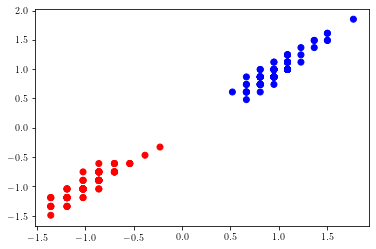

In [38]:
#Show the 2D projection

vectors = X #Assign as vectors

scaler = StandardScaler() #For normalising the data

colors = []

for i in range(n_samples):
    colors.append('blue') #Blue if in state 0
    
for i in range(n_samples,2*n_samples):
    colors.append('red') #Red if in state 1
    
scaler.fit(vectors)
vectors_t = scaler.transform(vectors)
    
#Principle Component Analysis
pca = PCA(2,svd_solver='full')
pca.fit(vectors_t)

#Plot projection
plt.scatter(vectors_t[:,0],vectors_t[:,1],c=colors)
print('Number of components is',pca.n_components_)